In [1]:
# for reading data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [2]:
# read in the data
# url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/639388c2cbc2120a14dcf466e85730eb8be498bb/iris.csv'
df = pd.read_csv('../data/wildfire_dataset.csv')

# shuffle the dataset! 
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
le = LabelEncoder()
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['STATE'] = le.fit_transform(df['STATE'])
df['DATE'] = le.fit_transform(df['DATE'])

df = df.drop('OBJECTID',axis=1)
df = df.drop('NWCG_REPORTING_UNIT_NAME',axis=1)
df = df.drop('FIRE_SIZE_CLASS',axis=1)
df = df.drop('OWNER_DESCR',axis=1)
df = df.drop('DATE',axis=1)
df = df.dropna()
    
# split into X and Y
# Y = df['species']
# X = df.drop(['species'], axis=1)

Y = df['STAT_CAUSE_DESCR']
X = df.drop(['STAT_CAUSE_DESCR'], axis=1)

print(X.shape)
print(Y.shape)
# convert to numpy arrays
X = np.array(X)

(1389937, 5)
(1389937,)


In [4]:
# # show Y
# Y.head()

# ## 0        setosa
# ## 1     virginica
# ## 2    versicolor
# ## 3     virginica
# ## 4        setosa

# work with labels
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

print(encoded_Y)

print(dummy_y)

[0 1 0 ... 0 0 0]
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [5]:
# build a model
model = Sequential()
model.add(Dense(16, input_shape=(X.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dense(8, activation='relu')) # input shape is (features,)
model.add(Dense(3, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                96        
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


2022-11-16 00:35:57.939369: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-16 00:35:57.939483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
import keras
from keras.callbacks import EarlyStopping

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# now we just update our model fit call
history = model.fit(X,
                    dummy_y,
                    callbacks=[es],
                    epochs=8000000, # you can set this to a big number!
                    batch_size=300,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/8000000


2022-11-16 00:35:58.085070: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-16 00:35:58.296008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3707/3707 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.7640

2022-11-16 00:36:39.507881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3707/3707 [==============================] - 47s 13ms/step - loss: 0.6941 - accuracy: 0.7640 - val_loss: 0.5740 - val_accuracy: 0.7733
Epoch 2/8000000
3707/3707 [==============================] - 44s 12ms/step - loss: 0.5496 - accuracy: 0.7902 - val_loss: 0.5869 - val_accuracy: 0.7581
Epoch 3/8000000
3707/3707 [==============================] - 44s 12ms/step - loss: 0.5136 - accuracy: 0.7982 - val_loss: 0.5263 - val_accuracy: 0.7937
Epoch 4/8000000
3707/3707 [==============================] - 44s 12ms/step - loss: 0.5054 - accuracy: 0.8026 - val_loss: 0.4971 - val_accuracy: 0.8135
Epoch 5/8000000
3707/3707 [==============================] - 44s 12ms/step - loss: 0.5015 - accuracy: 0.8067 - val_loss: 0.4990 - val_accuracy: 0.8071
Epoch 6/8000000
3707/3707 [==============================] - 44s 12ms/step - loss: 0.4946 - accuracy: 0.8101 - val_loss: 0.4969 - val_accuracy: 0.8112
Epoch 7/8000000
3707/3707 [==============================] - 44s 12ms/step - loss: 0.4895 - accuracy: 0.8127 -

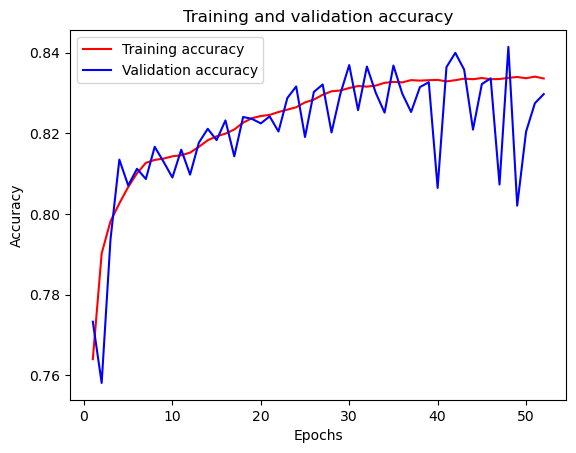

In [7]:
history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = model.predict(X) # see how the model did!
print(preds[0]) # i'm spreading that prediction across three nodes and they sum to 1
print(np.sum(preds[0])) # sum it up! Should be 1
## [9.9999988e-01 1.3509347e-07 6.7064638e-16]
## 1.0

# Almost a perfect prediction
# actual is left, predicted is top
# names can be found by inspecting Y
matrix = confusion_matrix(dummy_y.argmax(axis=1), preds.argmax(axis=1))
matrix
## array([[50,  0,  0],
##        [ 0, 46,  4],
##        [ 0,  1, 49]])


# more detail on how well things were predicted
print(classification_report(dummy_y.argmax(axis=1), preds.argmax(axis=1)))
##               precision    recall  f1-score   support
## 
##            0       1.00      1.00      1.00        50
##            1       0.98      0.92      0.95        50
##            2       0.92      0.98      0.95        50
## 
##     accuracy                           0.97       150
##    macro avg       0.97      0.97      0.97       150
## weighted avg       0.97      0.97      0.97       150

   89/43436 [..............................] - ETA: 1:15

2022-11-16 01:14:09.725239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43436/43436 [==============================] - 71s 2ms/step
[0.9088226  0.028437   0.06274036]
1.0


/Users/maxencecabiddu/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maxencecabiddu/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.88      0.93      0.90   1048270
           1       0.69      0.70      0.70    278468
           2       0.00      0.00      0.00     63199

    accuracy                           0.84   1389937
   macro avg       0.52      0.54      0.53   1389937
weighted avg       0.80      0.84      0.82   1389937



/Users/maxencecabiddu/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
